# Problem 2
## Set up the notebook environment

In [1]:
""" Setup the environment for the notebook """ 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils.stock_loader as stock_loader

""" Importlib is used to reload the module after changes.
    This is useful when developing the module and testing it in the notebook.
    The reload is done by running this cell again.

    REMEMBER TO ADD THE MODULE BELOW FOR RELOADING.
"""

import utils.evolutionary_logger

import importlib
importlib.reload(stock_loader)
importlib.reload(utils.evolutionary_logger)

from utils.evolutionary_logger import EvolutionaryLogger

## Import the stocks

In [2]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'period': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'UAA', 'SNAP','NOD.OL', 'TSLA', 'TEL.OL', 'MPCC.OL', 'AKAST.OL', 'BA', 'ADBE', 'ORCL', 'NTDOY', 'PCG', 'KHC', 'SONY']
stock_data = pd.DataFrame({ticker: stock_loader.load_or_download_stock_data(ticker, **DATA_PERIOD) for ticker in STOCK_TICKERS})
monthly_returns = stock_data.resample('ME').last().pct_change().dropna()

print(f"Number of stocks: {len(monthly_returns.columns)}")

Number of stocks: 20


## Plot the monthly returns in percent for each stock

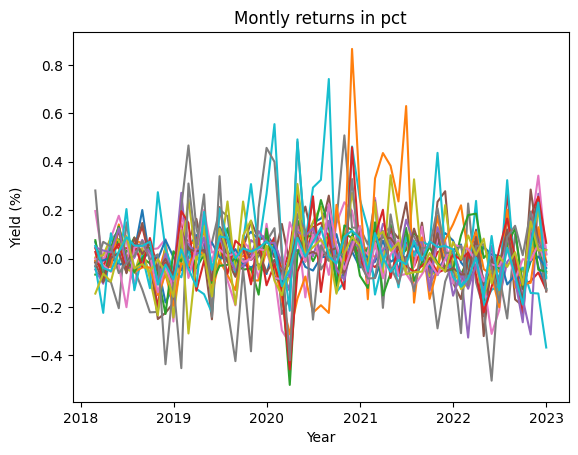

In [3]:
plt.plot(monthly_returns)
plt.title('Montly returns in pct')
plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.show()

## Creating functions to run the algorithms and plot the weights

In [4]:
from typing import Callable
from ea.strategy import Strategy

def run_for(get_strategy: Callable[[], Strategy], times: int, generations: int, n_population: int, logger: EvolutionaryLogger):
    all_p = pd.DataFrame()
    for run in range(times):
        population = get_strategy()
        population = population.fit(n_genes=len(STOCK_TICKERS), logger=logger, n_population=n_population, n_generations=generations)
        best_portfolio = population[0]

        assert len(best_portfolio.chromosome) == len(STOCK_TICKERS)

        portfolio = {ticker: value for ticker, value in zip(STOCK_TICKERS, best_portfolio.chromosome)}
        portfolio['returns'] = best_portfolio.fitness
        
        # Calculate portfolio risk using the covariance matrix of monthly returns
        weights = np.array(best_portfolio.chromosome)
        cov_matrix = monthly_returns.cov()
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio['risk'] = np.sqrt(portfolio_variance)
        
        portfolio_df = pd.DataFrame(portfolio, index=[run])
        all_p = pd.concat([all_p, portfolio_df])
     
        logger.flush()
    
    plt.title('Returns vs. Risk')
    plt.plot(all_p['returns'], c='green')
    plt.plot(all_p['risk'], c='red')
    plt.legend(['Returns', 'Risk'], bbox_to_anchor=(1.25, 0.5))
    plt.show()

    return all_p

def plot_weights(data: pd.DataFrame):
    rows = data.shape[0]
    for run in range(rows):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Extract data for the current run
        run_data = data.iloc[run]
        
        # Create the histogram
        ax.bar(STOCK_TICKERS, run_data[STOCK_TICKERS])
        
        ax.set_xlabel('Stock Tickers')
        ax.set_ylabel('Weight')
        ax.set_title(f'Stock Weights for Run {run + 1}')
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on top of each bar
        for i, v in enumerate(run_data[STOCK_TICKERS]):
            ax.text(i, v, f'{v:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

## Call the EvolutionaryFactory class

In [5]:
from ea.ea_factory import EvolutionaryFactory
factory = EvolutionaryFactory(monthly_returns=monthly_returns)

## Run basic EP

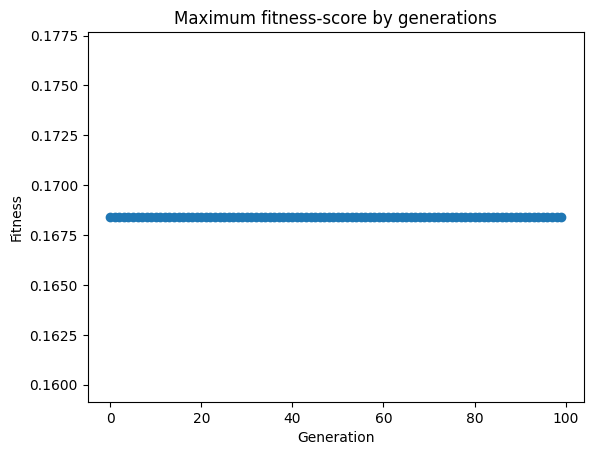

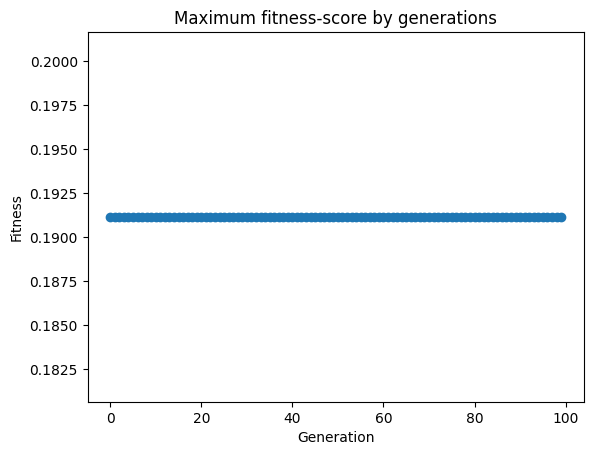

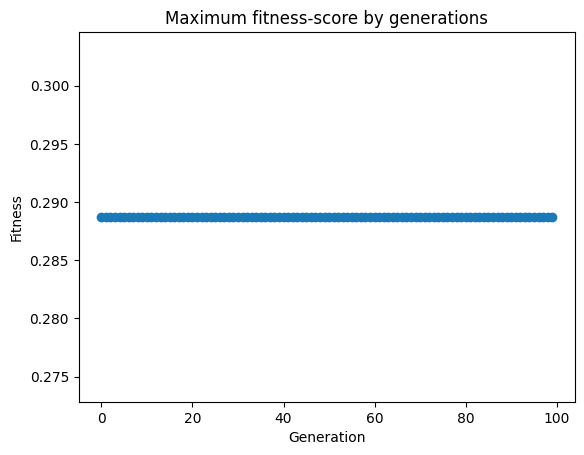

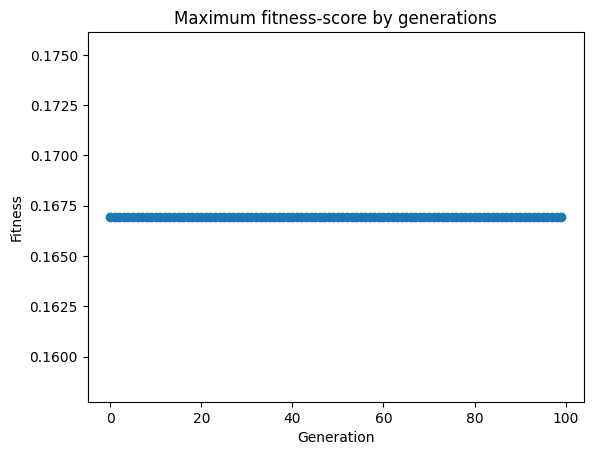

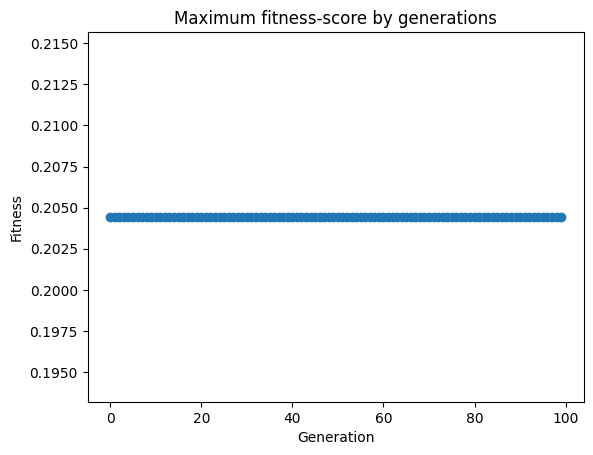

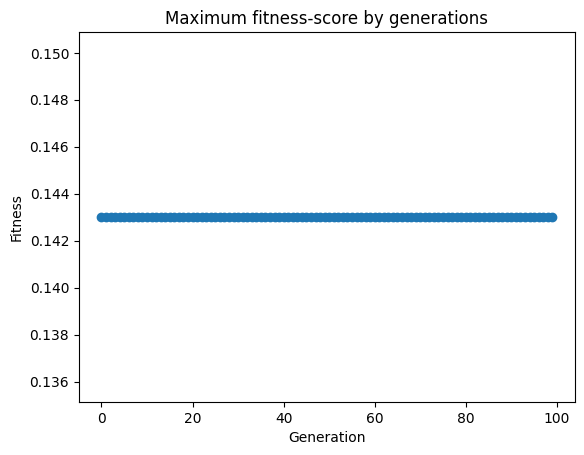

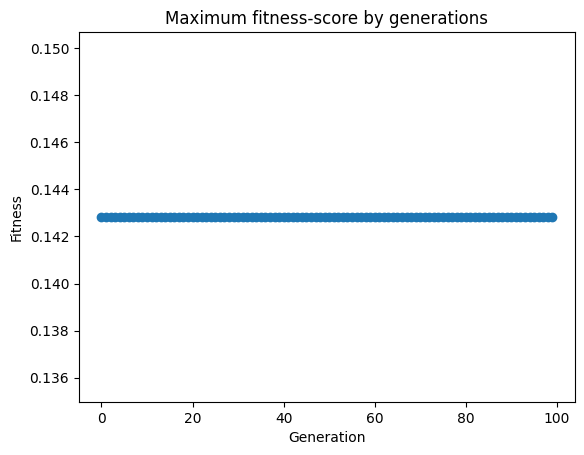

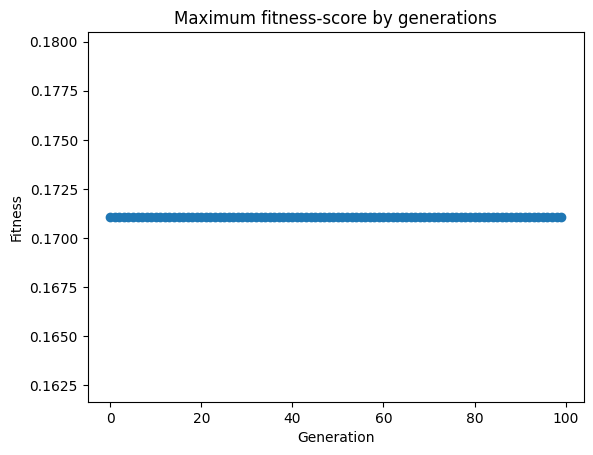

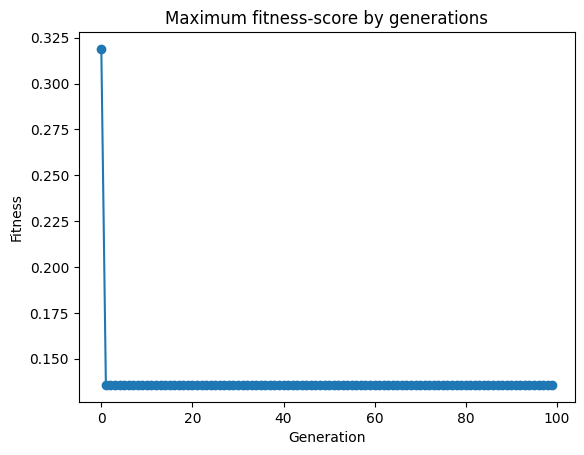

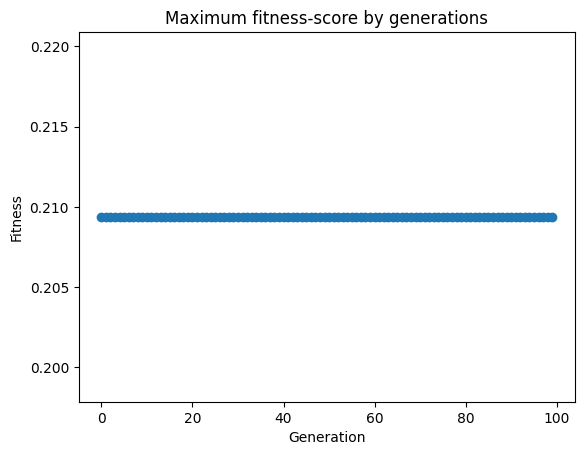

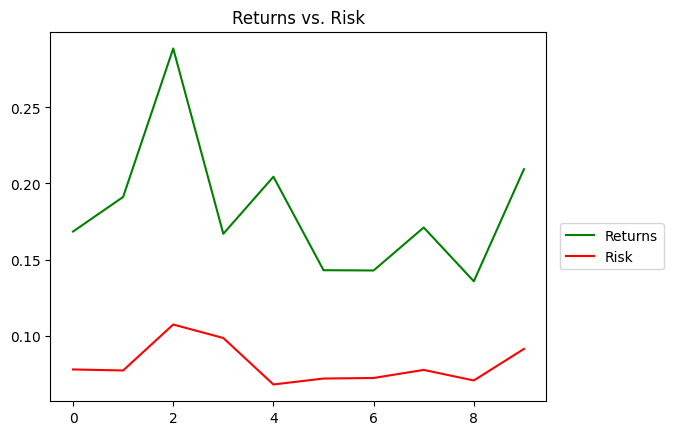

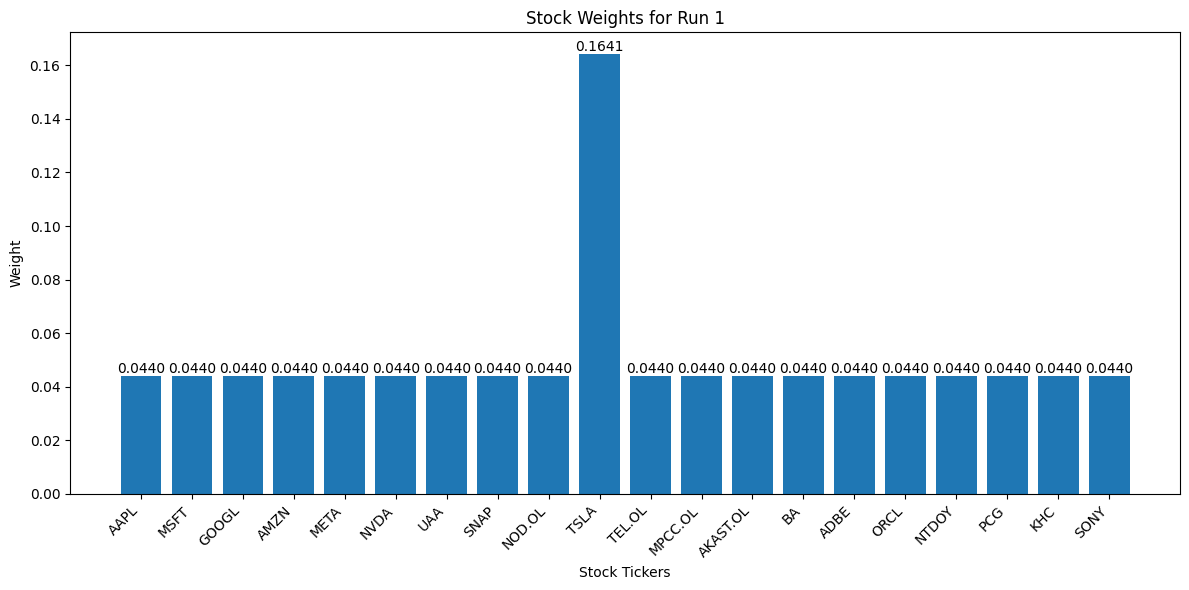

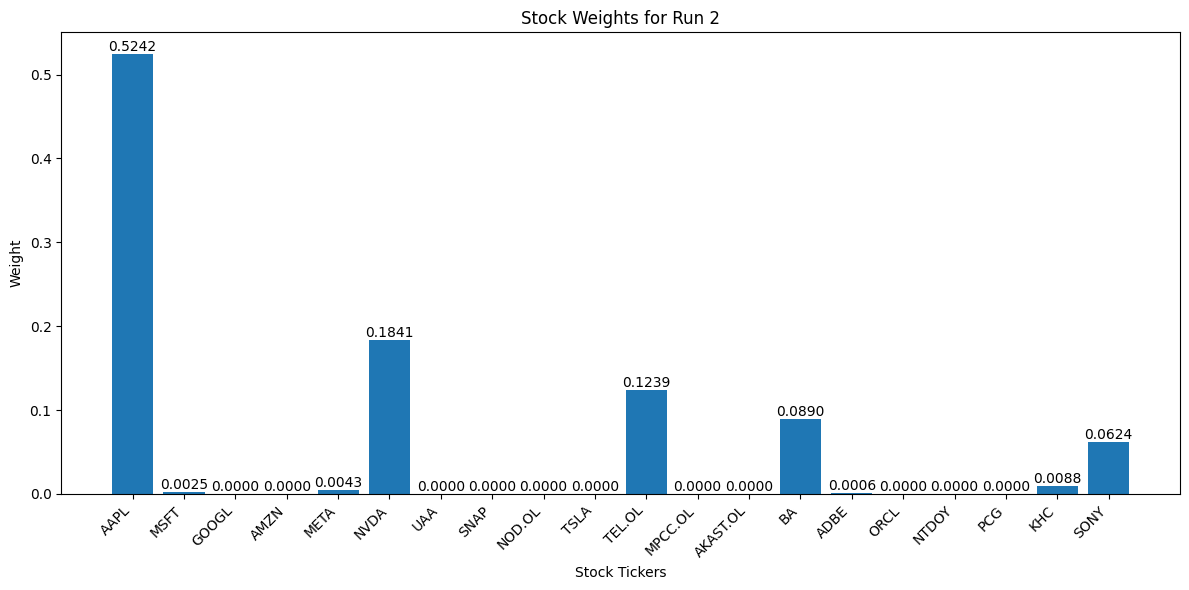

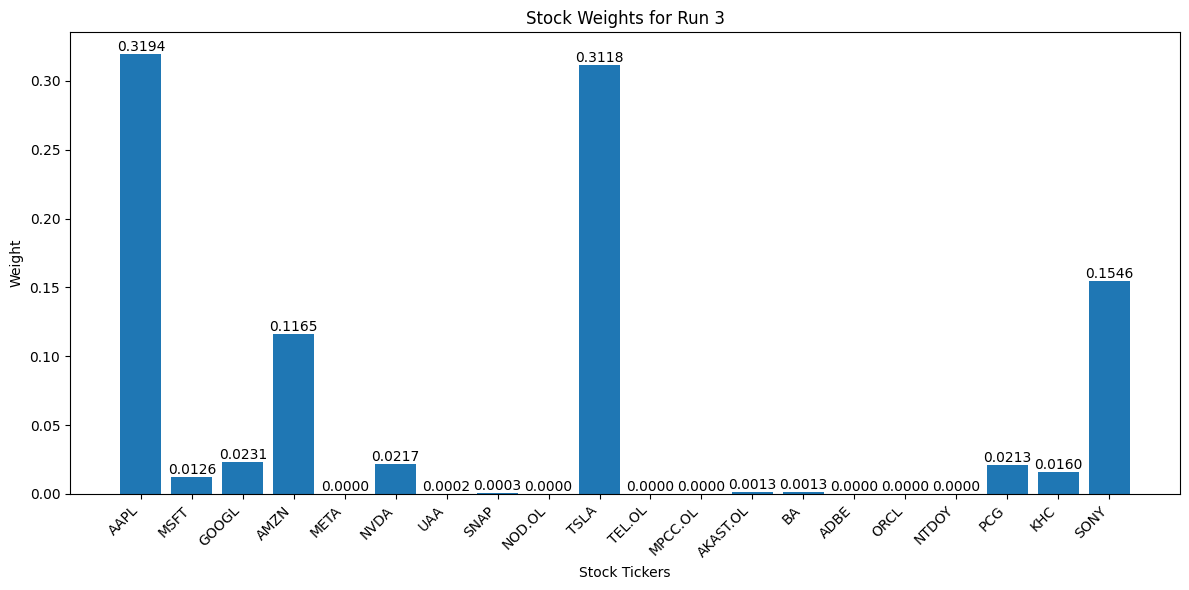

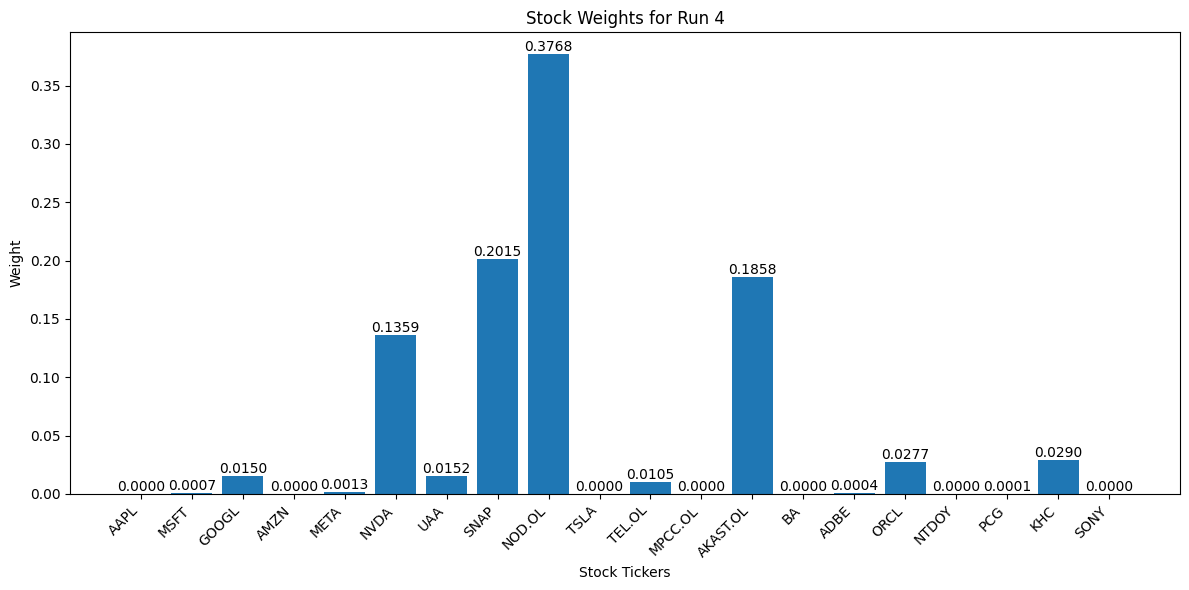

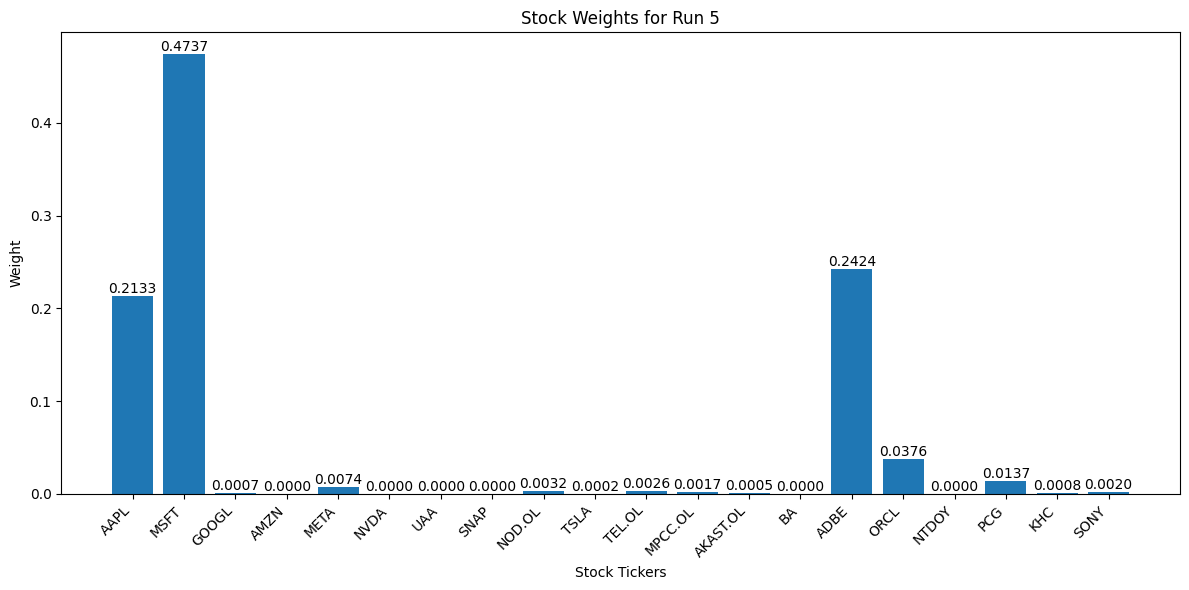

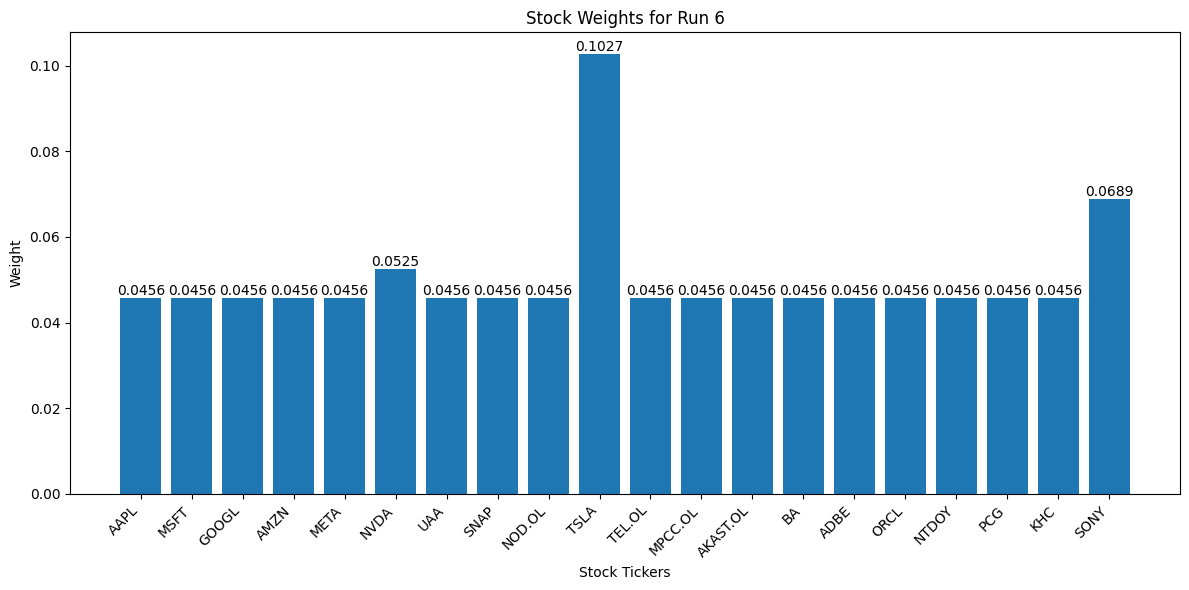

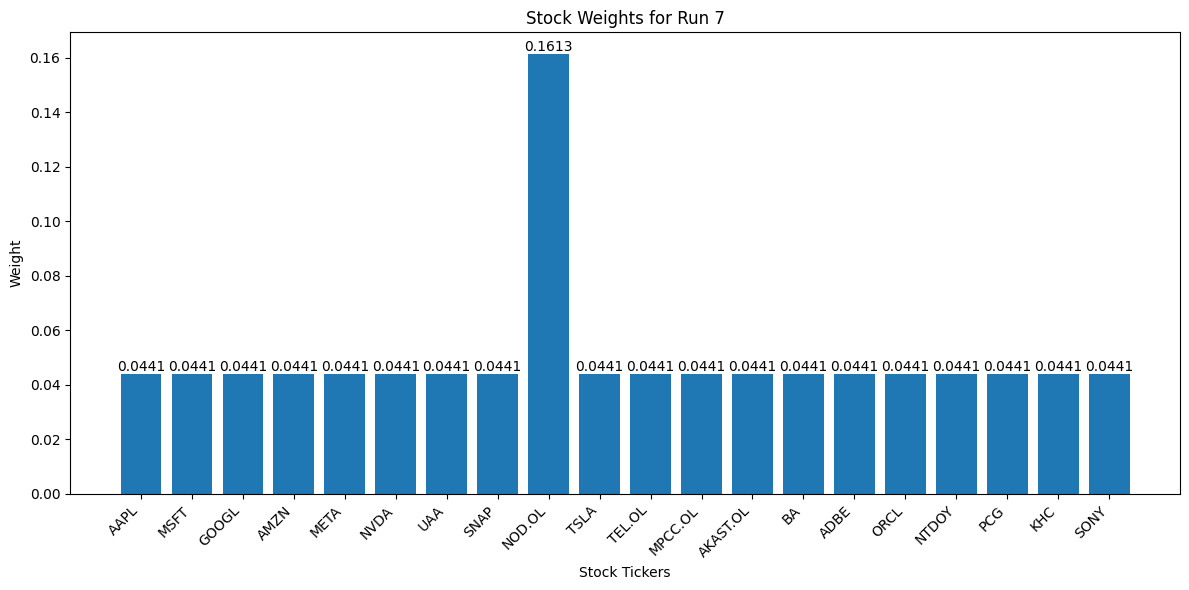

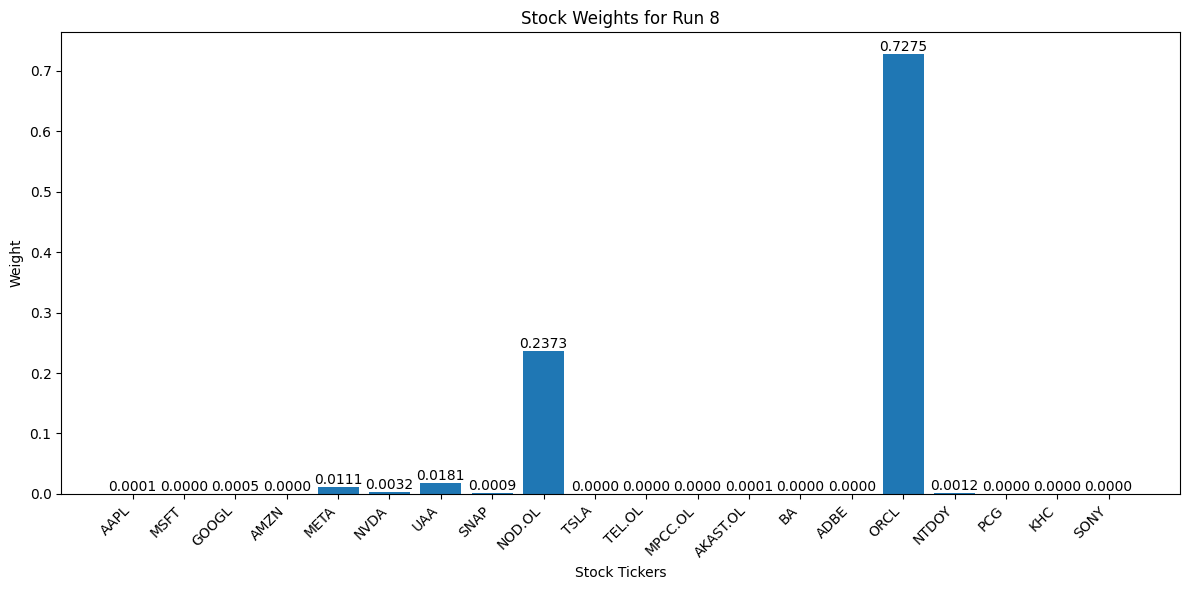

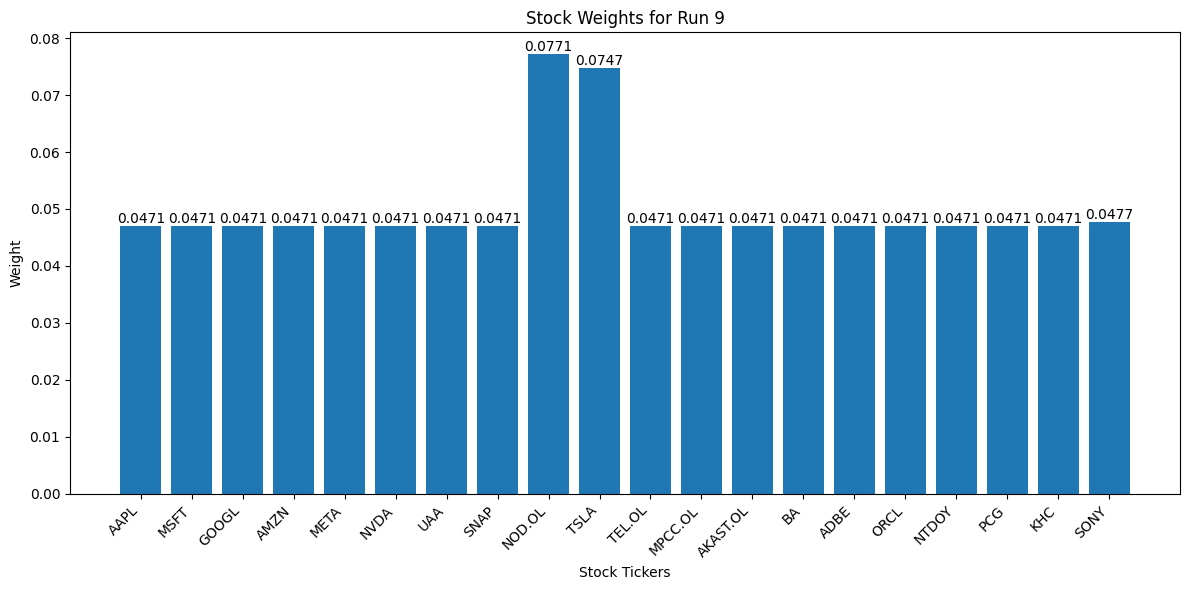

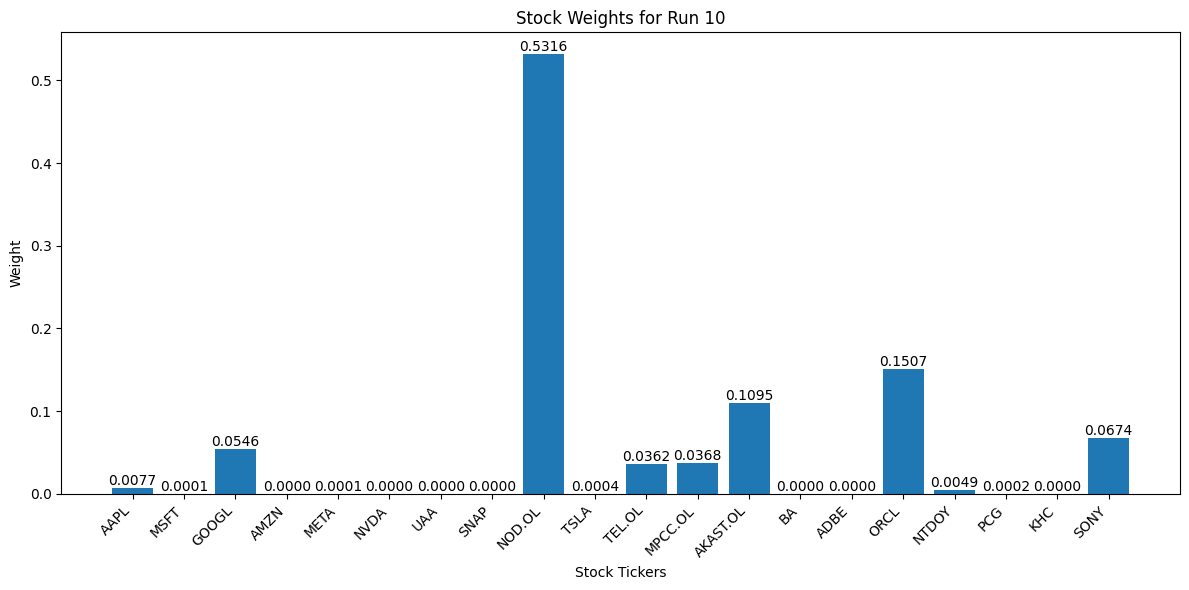

In [6]:
basic_ep = lambda: factory.create_basic_ep(learning_rate=0.1, n_offsprings=5*7, n_population=5)
logger_basic_ep = EvolutionaryLogger()
basic_ep_data = run_for(basic_ep, times=10, generations=100, n_population=10, logger=logger_basic_ep)
plot_weights(basic_ep_data)

## Run advanced EP with one-step mutator

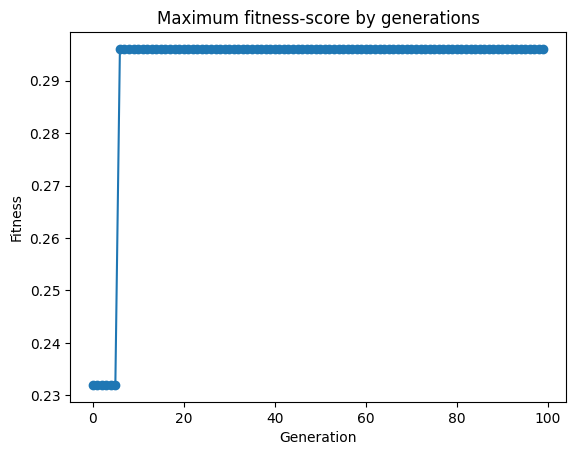

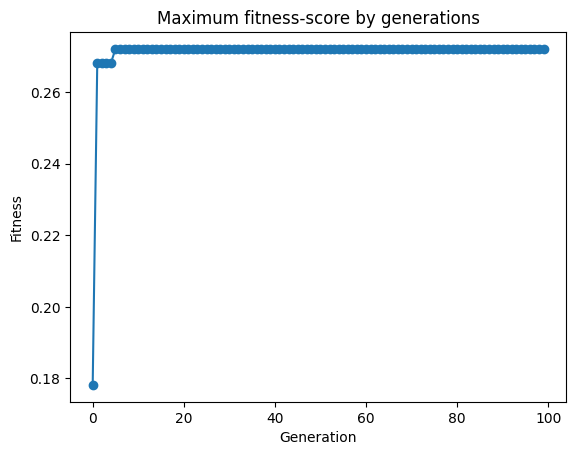

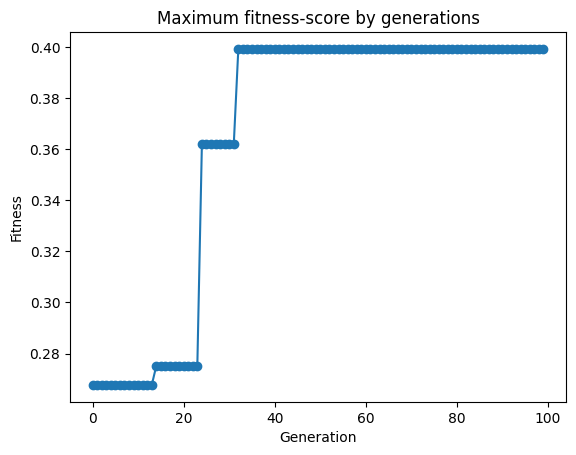

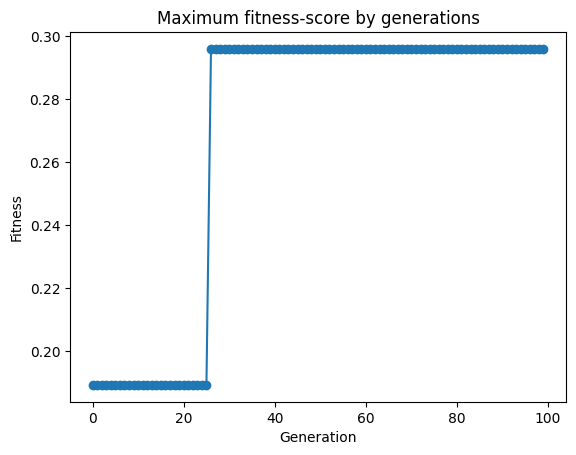

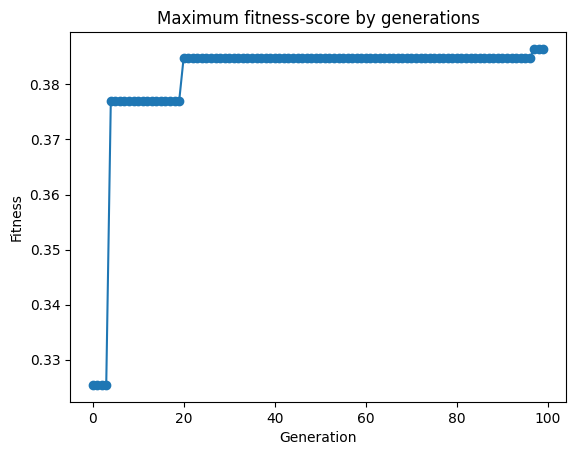

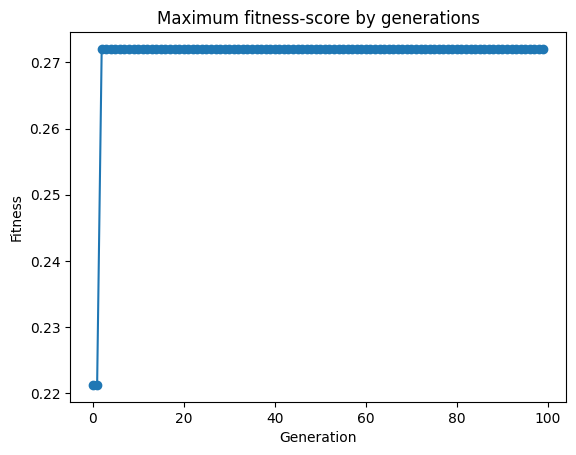

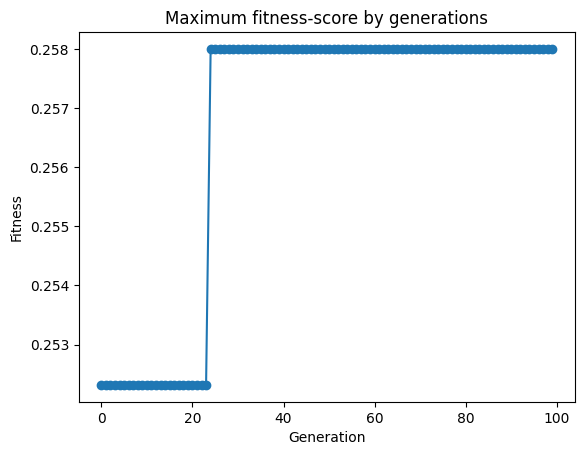

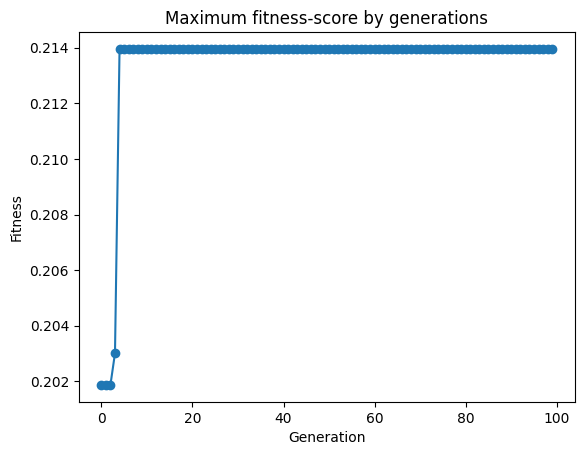

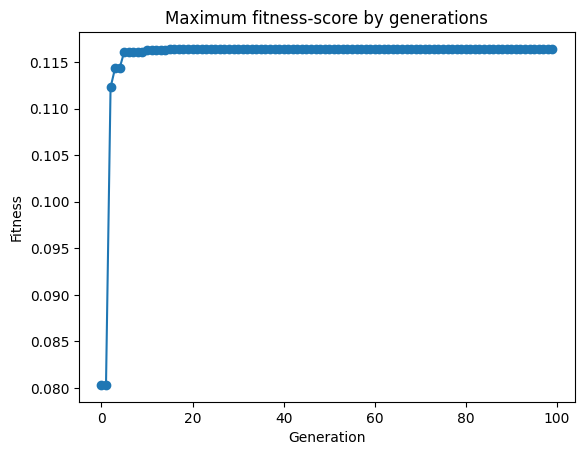

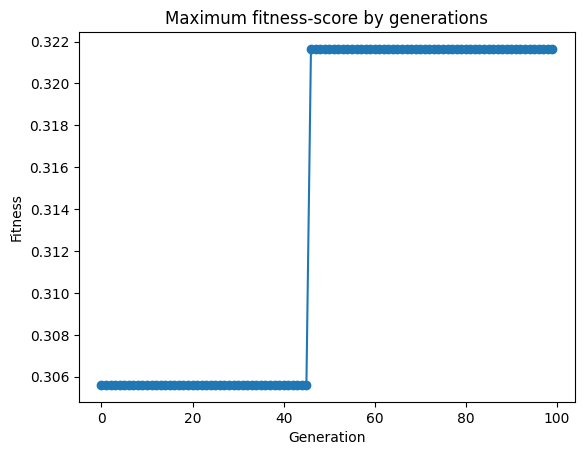

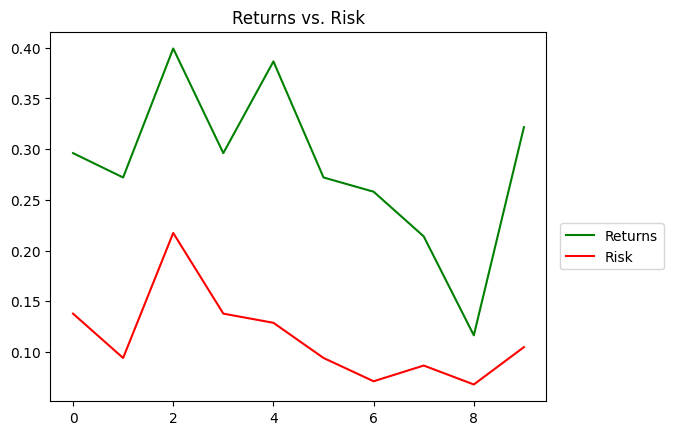

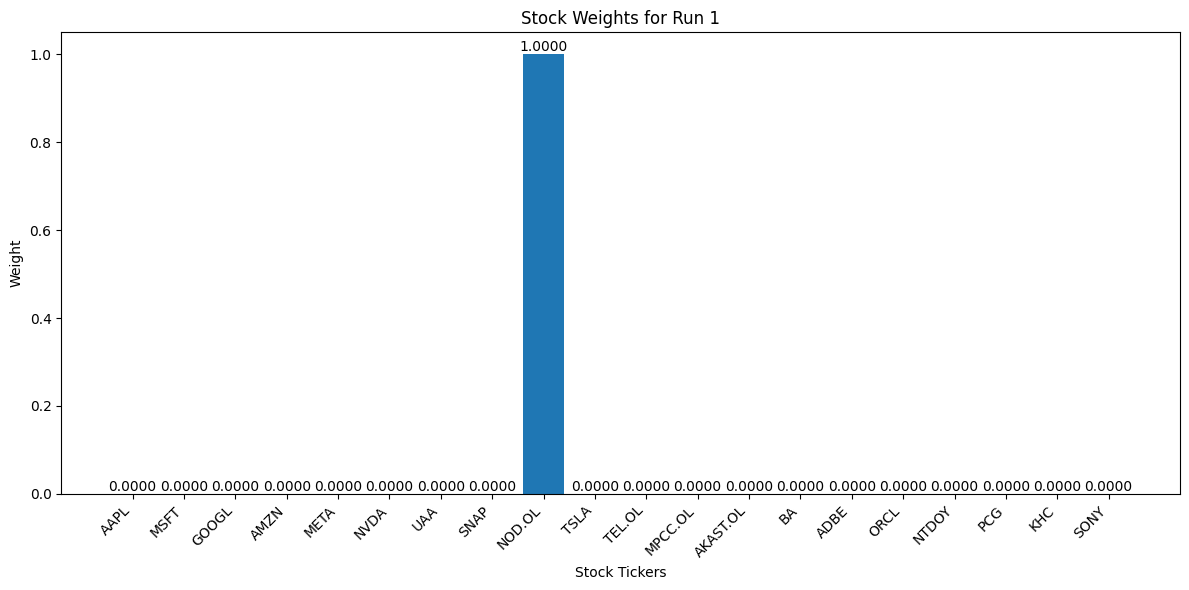

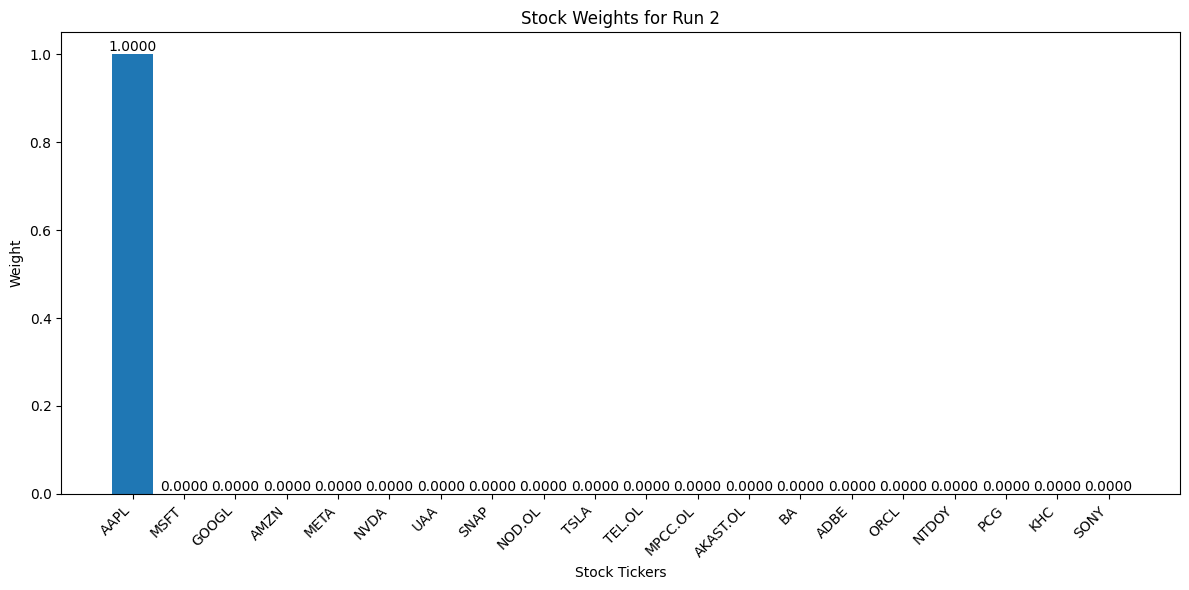

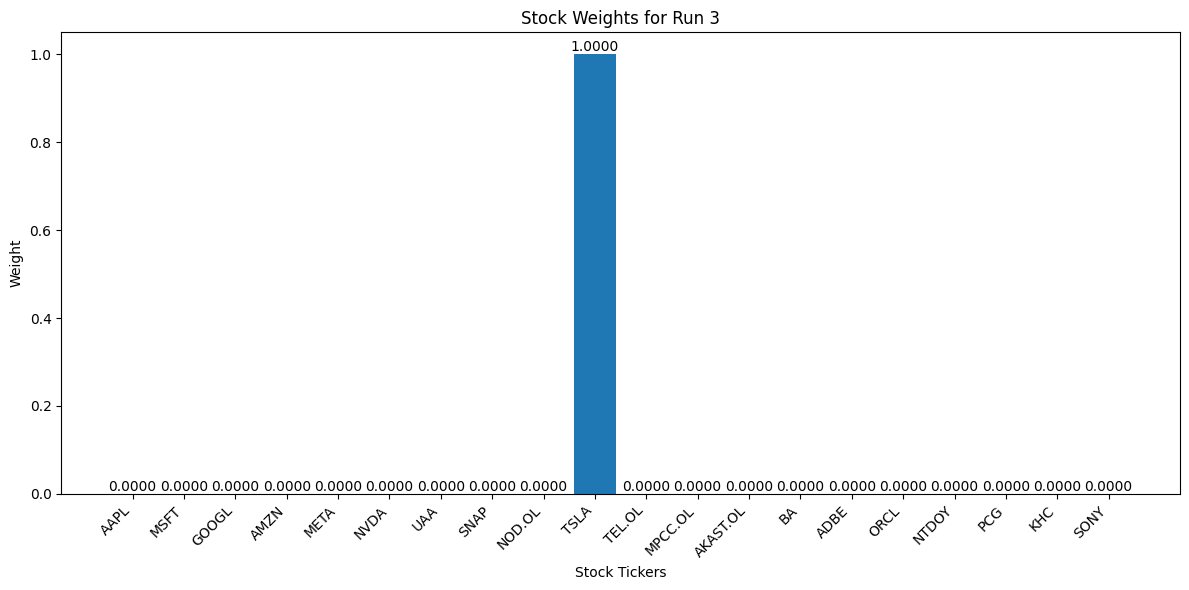

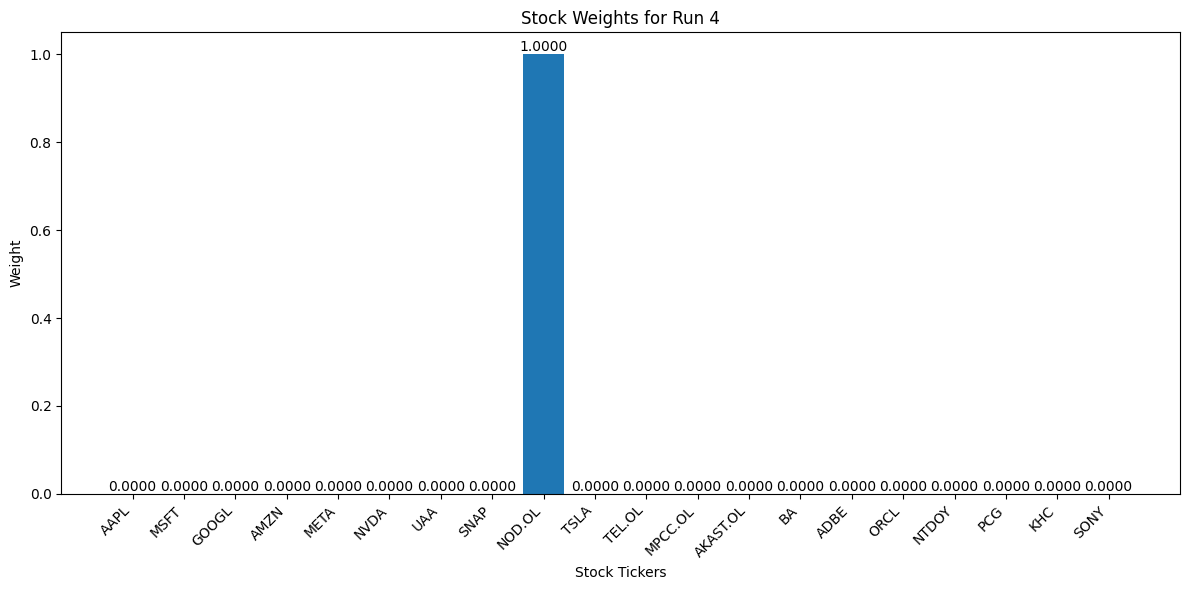

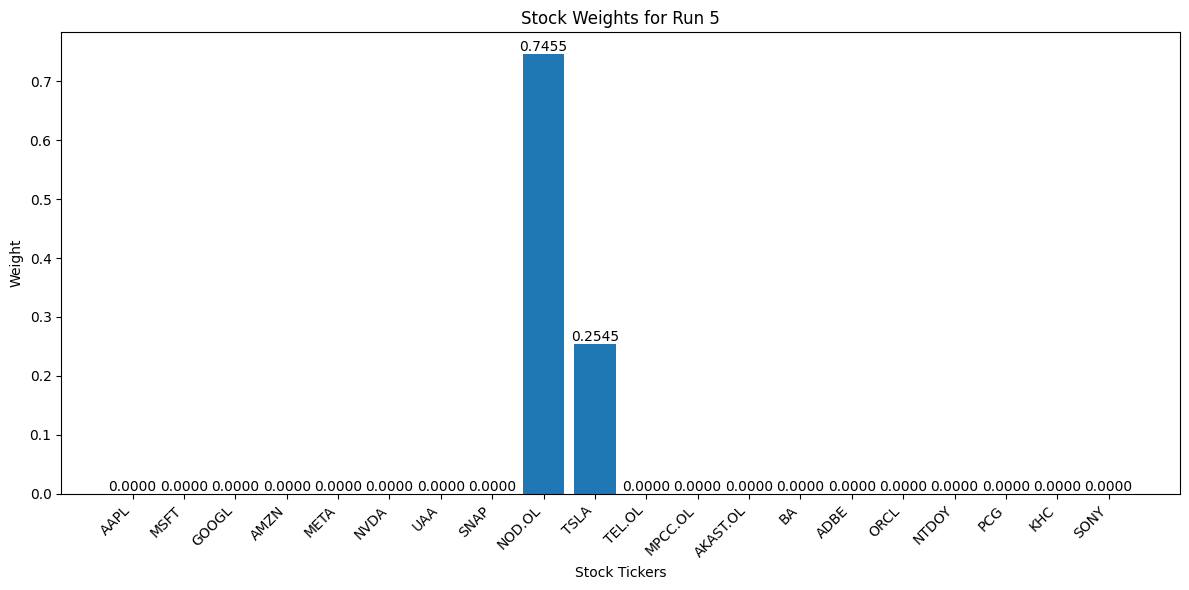

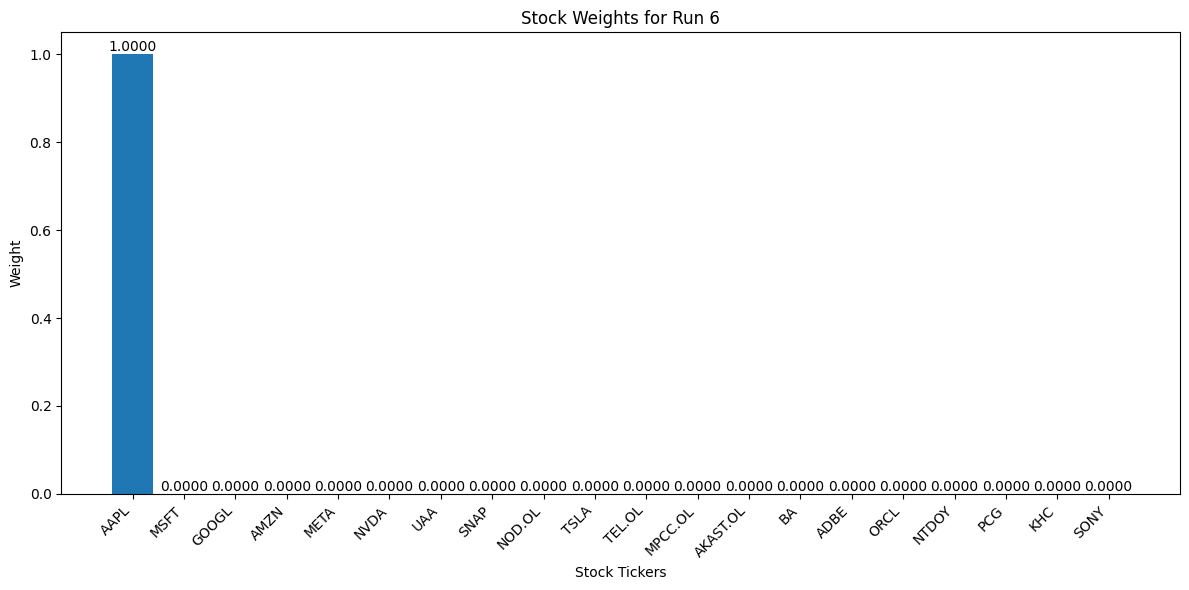

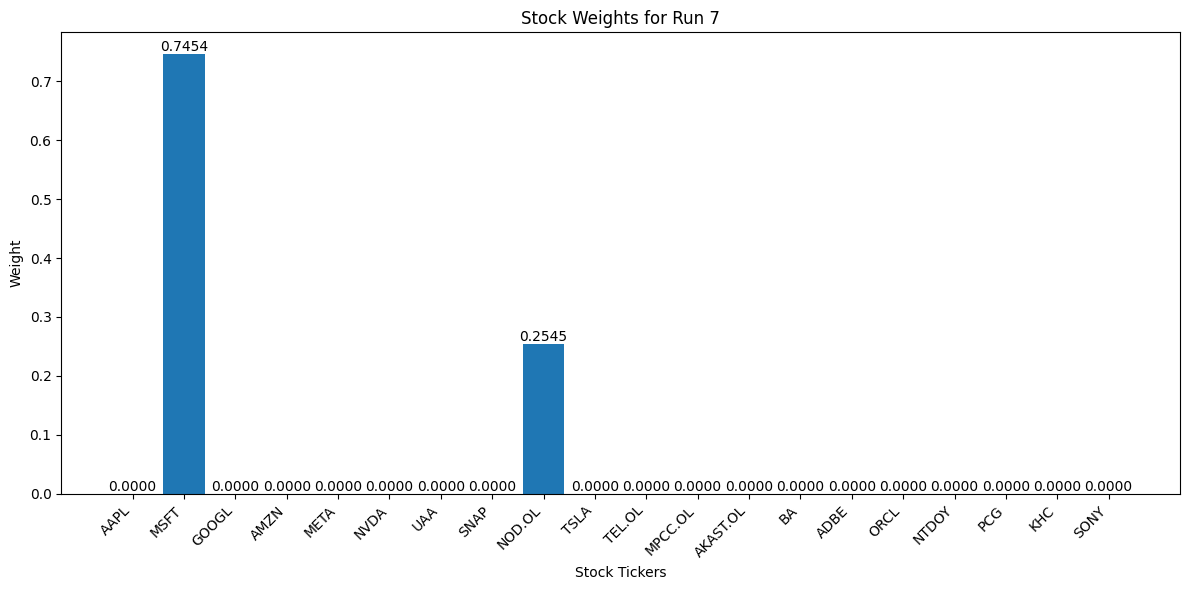

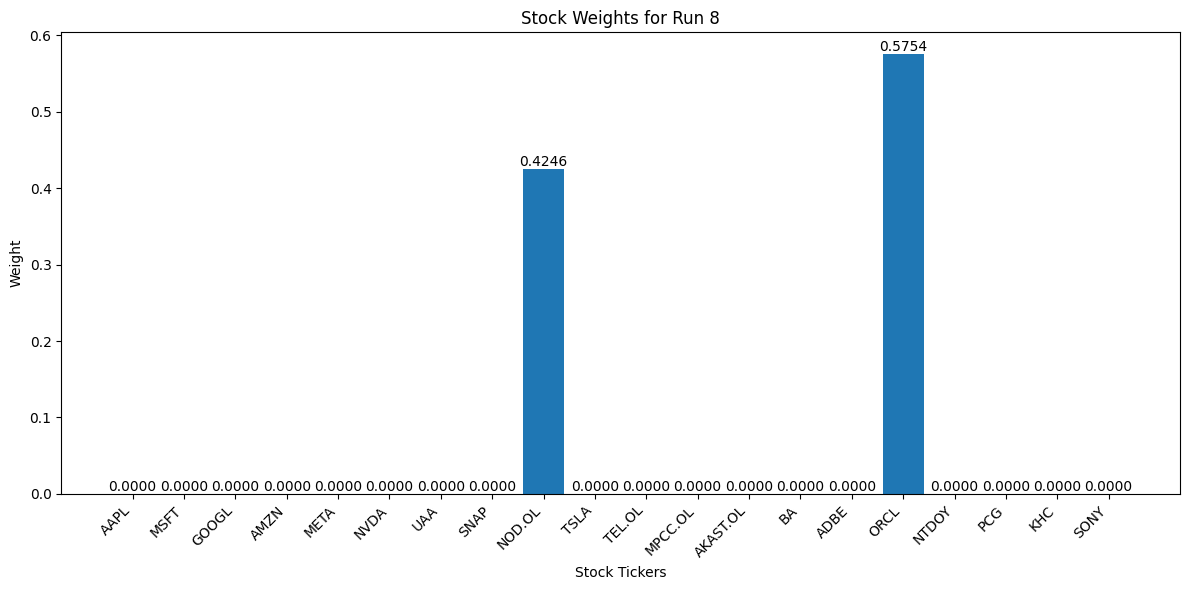

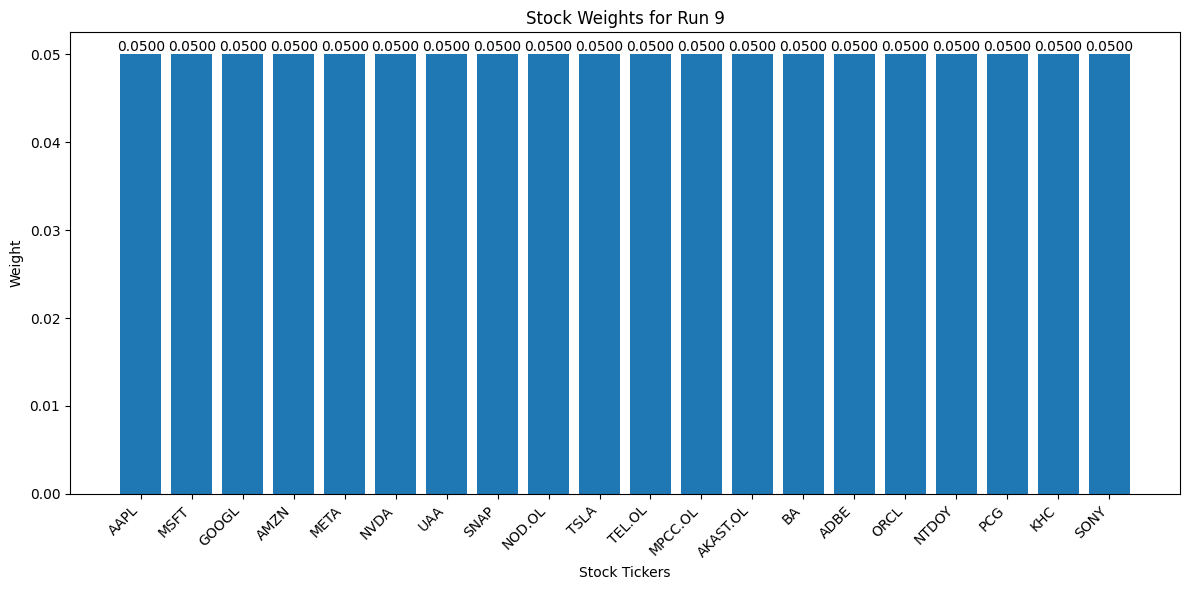

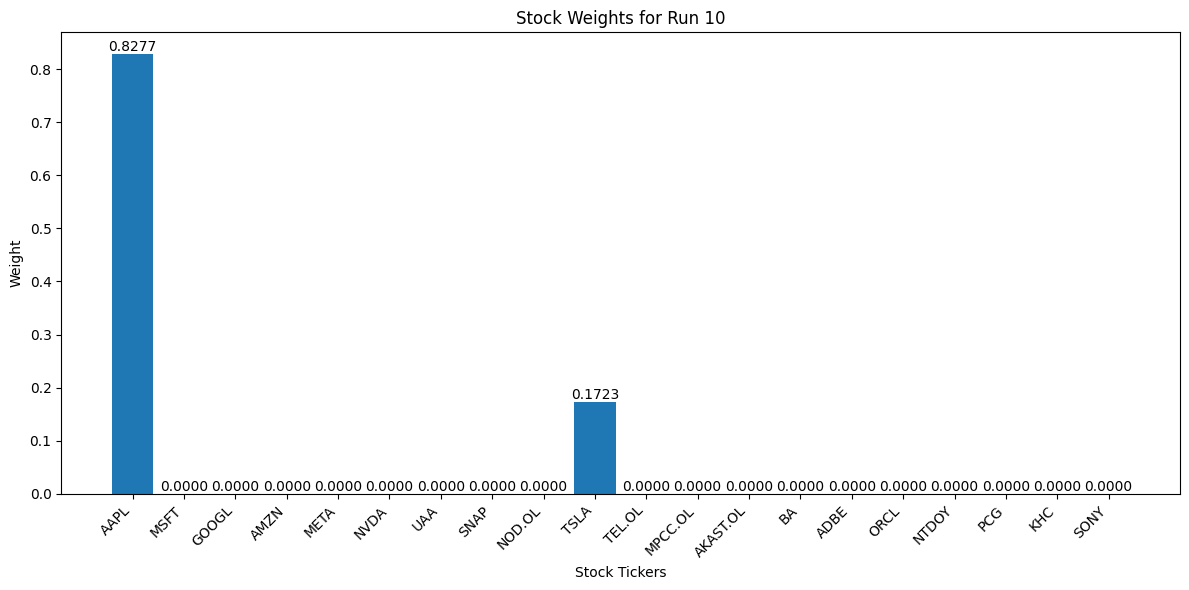

In [7]:
advanced_ep = lambda: factory.create_advanced_ep(learning_rate=0.1, mutation_rate=0.1, n_offsprings=5*7, n_population=5)
logger_advanced_ep = EvolutionaryLogger()
advanced_ep_data = run_for(advanced_ep, times=10, generations=100, n_population=10, logger=logger_advanced_ep)
plot_weights(advanced_ep_data)

## Run basic ES

In [8]:
# basic_es = lambda: factory.create_basic_es(learning_rate=0.1, n_offsprings=5*7, n_population=5, recombination_rate=0.5) 
# basic_es_data = run_for(basic_es, times=10, generations=100, n_population=10, logger=EvolutionaryLogger())
# plot_weights(basic_es_data)

## Run advanced ES with one-step mutator

In [9]:
# advanced_es_one_step = lambda:factory.create_advanced_es_one_step(learning_rate=0.1, n_offsprings=5*7, n_population=5, mutation_rate=0.1, recombination_rate=0.5)
# advanced_es_one_step_data = run_for(advanced_es_one_step, 10, 100, 10, EvolutionaryLogger())
# plot_weights(advanced_es_one_step_data)

## Run (μ + λ) with N-step mutator

In [10]:
# mu_plus_lambda = lambda:factory.create_mu_plus_lambda(learning_rate=0.1, n_offsprings=5*7, n_population=5, mutation_rate=0.1, recombination_rate=0.5)
# mu_plus_lambda_data = run_for(mu_plus_lambda, 10, 100, 10, EvolutionaryLogger())
# plot_weights(mu_plus_lambda_data)

## Run (μ, λ) with N-step mutator

In [11]:
# mu_comma_lambda = lambda:factory.create_mu_comma_lambda(learning_rate=0.1, n_offsprings=5*7, n_population=5, mutation_rate=0.1, recombination_rate=0.5)
# mu_comma_lambda_data = run_for(mu_comma_lambda, 10, 100, 10, EvolutionaryLogger())
# plot_weights(mu_comma_lambda_data)

## Data collection and analysis

,Algorithm,Mean Return,Stability (Std Return)
0,basic_ep_data,0.182169,0.045278
1,advanced_ep_data,0.283183,0.081255


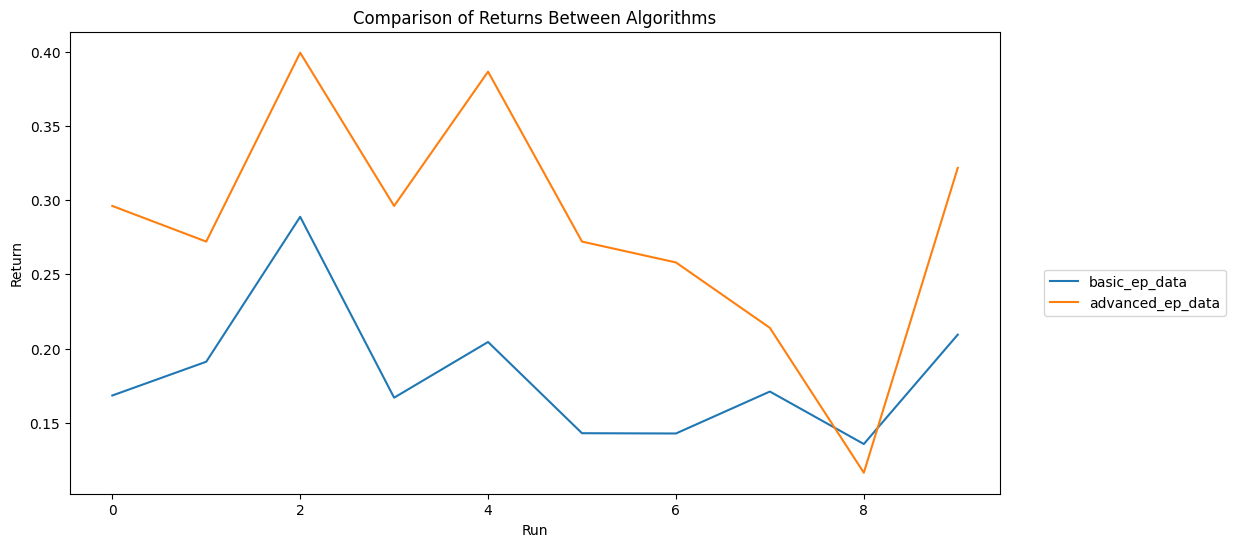

In [13]:
from utils import performance_metrics as pm

#pm.compare_returns(basic_ep_data, advanced_ep_data, basic_es_data, advanced_es_one_step_data, mu_plus_lambda_data, mu_comma_lambda_data)
pm.compare_returns(basic_ep_data=basic_ep_data, advanced_ep_data=advanced_ep_data)
#pm.plot_convergence(basic_ep=logger_basic_ep, advanced_ep=logger_advanced_ep)
